[env] Ep    1 | ep_reward=9.0 | avg100=9.0 | eps=0.995
[env] Ep    2 | ep_reward=33.0 | avg100=21.0 | eps=0.990
[env] Ep    3 | ep_reward=19.0 | avg100=20.3 | eps=0.985
[env] Ep    4 | ep_reward=23.0 | avg100=21.0 | eps=0.980
[env] Ep    5 | ep_reward=28.0 | avg100=22.4 | eps=0.975
[env] Ep    6 | ep_reward=10.0 | avg100=20.3 | eps=0.970
[env] Ep    7 | ep_reward=11.0 | avg100=19.0 | eps=0.966
[env] Ep    8 | ep_reward=30.0 | avg100=20.4 | eps=0.961
[env] Ep    9 | ep_reward=15.0 | avg100=19.8 | eps=0.956
[env] Ep   10 | ep_reward=22.0 | avg100=20.0 | eps=0.951
[env] Ep   11 | ep_reward=24.0 | avg100=20.4 | eps=0.946
[env] Ep   12 | ep_reward=13.0 | avg100=19.8 | eps=0.942
[env] Ep   13 | ep_reward=31.0 | avg100=20.6 | eps=0.937
[env] Ep   14 | ep_reward=12.0 | avg100=20.0 | eps=0.932
[env] Ep   15 | ep_reward=11.0 | avg100=19.4 | eps=0.928
[env] Ep   16 | ep_reward=11.0 | avg100=18.9 | eps=0.923
[env] Ep   17 | ep_reward=34.0 | avg100=19.8 | eps=0.918
[env] Ep   18 | ep_reward=11.0 | 

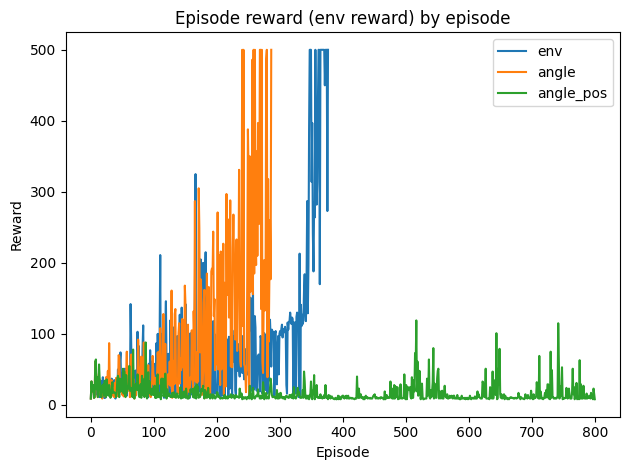

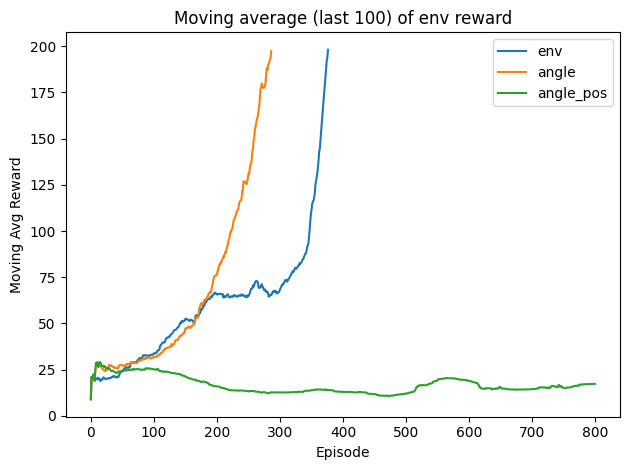

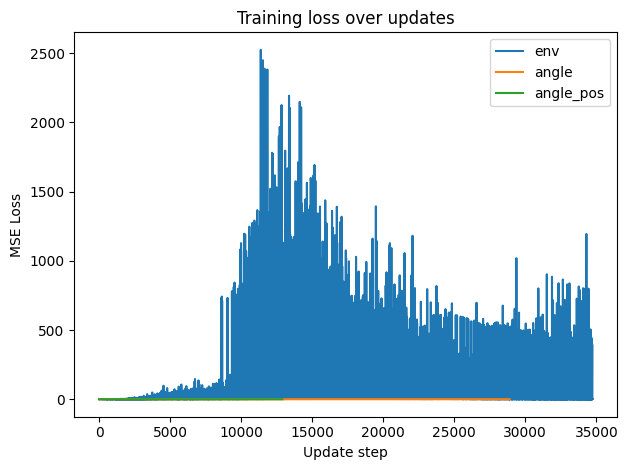

In [ ]:
# dqn_cartpole_compare.py
# End-to-end DQN for CartPole-v1 comparing three reward schemes:
#   1) Original env reward
#   2) -|pole_angle|
#   3) -(|pole_angle| + |cart_position|)



# This is without hyperparameter varations. just to see how dqn works

import math
import random
from collections import deque, namedtuple
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

# ----------------------------
# Config / Hyperparameters
# ----------------------------
ENV_ID = "CartPole-v1"
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
REPLAY_CAPACITY = 10_000
TARGET_UPDATE_STEPS = 100           # steps between target network syncs
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995                   # per episode
MAX_EPISODES = 800                  # safety cap
SOLVED_THRESHOLD = 195.0
MOVING_AVG_WINDOW = 100
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Utilities
# ----------------------------
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, state_dim=4, action_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def set_seed(env, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)

# Reward shaping helpers (CartPole state = [x, x_dot, theta, theta_dot])
def reward_original(env_reward, state, next_state):
    return env_reward

def reward_angle(env_reward, state, next_state):
    theta = next_state[2]
    return -abs(theta)

def reward_angle_pos(env_reward, state, next_state):
    x = next_state[0]
    theta = next_state[2]
    return -(abs(theta) + abs(x))

REWARD_SCHEMES = {
    "env": reward_original,
    "angle": reward_angle,
    "angle_pos": reward_angle_pos,
}

def select_action(policy_net, state_t, eps, n_actions):
    if random.random() < eps:
        return torch.tensor([[random.randrange(n_actions)]], device=DEVICE, dtype=torch.long)
    with torch.no_grad():
        q_vals = policy_net(state_t)
        return q_vals.argmax(dim=1).view(1, 1)

def optimize_model(policy_net, target_net, optimizer, memory):
    if len(memory) < BATCH_SIZE:
        return 0.0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*transitions)

    non_final_mask = torch.tensor([not d for d in batch.done], device=DEVICE, dtype=torch.bool)
    non_final_next_states = torch.stack([torch.tensor(s, dtype=torch.float32, device=DEVICE)
                                         for s, d in zip(batch.next_state, batch.done) if not d])
    state_batch = torch.stack([torch.tensor(s, dtype=torch.float32, device=DEVICE) for s in batch.state])
    action_batch = torch.tensor(batch.action, device=DEVICE, dtype=torch.long).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, device=DEVICE, dtype=torch.float32)

    # Q(s,a)
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze(1)

    # r + gamma * max_a' Q_target(s', a')
    next_q_values = torch.zeros(BATCH_SIZE, device=DEVICE)
    if non_final_mask.any():
        with torch.no_grad():
            next_q_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_q_values = reward_batch + GAMMA * next_q_values

    loss = nn.MSELoss()(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()
    return loss.item()

def run_experiment(reward_mode="env"):
    assert reward_mode in REWARD_SCHEMES
    env = gym.make(ENV_ID)
    set_seed(env, SEED)

    n_actions = env.action_space.n
    state_dim = env.observation_space.shape[0]

    policy_net = DQN(state_dim, n_actions).to(DEVICE)
    target_net = DQN(state_dim, n_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(REPLAY_CAPACITY)

    eps = EPS_START
    episode_rewards = []
    moving_avgs = []
    global_step = 0
    losses = []

    for i_episode in range(1, MAX_EPISODES + 1):
        state, _ = env.reset()
        state_t = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        ep_reward = 0.0

        for t in count():
            action = select_action(policy_net, state_t, eps, n_actions)
            next_state, env_reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # shaped reward
            shaped = REWARD_SCHEMES[reward_mode](env_reward, state, next_state)

            memory.push(state, action.item(), shaped, next_state, done)

            loss = optimize_model(policy_net, target_net, optimizer, memory)
            if loss:
                losses.append(loss)

            state = next_state
            state_t = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            ep_reward += env_reward  # track actual env reward for "solved" definition

            global_step += 1
            if global_step % TARGET_UPDATE_STEPS == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        episode_rewards.append(ep_reward)
        eps = max(EPS_END, eps * EPS_DECAY)

        # moving average for solved criterion (env reward)
        window = episode_rewards[-MOVING_AVG_WINDOW:]
        moving_avg = sum(window) / len(window)
        moving_avgs.append(moving_avg)

        print(f"[{reward_mode}] Ep {i_episode:4d} | ep_reward={ep_reward:.1f} | "
              f"avg{MOVING_AVG_WINDOW}={moving_avg:.1f} | eps={eps:.3f}")

        if len(episode_rewards) >= MOVING_AVG_WINDOW and moving_avg >= SOLVED_THRESHOLD:
            print(f"[{reward_mode}] Solved in {i_episode} episodes (avg >= {SOLVED_THRESHOLD}).")
            break

    env.close()
    return {
        "rewards": episode_rewards,
        "moving_avg": moving_avgs,
        "losses": losses,
    }

def plot_results(results_dict):
    plt.figure()
    for name, res in results_dict.items():
        rewards = res["rewards"]
        plt.plot(rewards, label=name)
    plt.title("Episode reward (env reward) by episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    for name, res in results_dict.items():
        ma = res["moving_avg"]
        plt.plot(ma, label=name)
    plt.title(f"Moving average (last {MOVING_AVG_WINDOW}) of env reward")
    plt.xlabel("Episode")
    plt.ylabel("Moving Avg Reward")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    for name, res in results_dict.items():
        if res["losses"]:
            plt.plot(res["losses"], label=name)
    plt.title("Training loss over updates")
    plt.xlabel("Update step")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    # Three runs with different reward schemes
    results = {}
    for mode in ["env", "angle", "angle_pos"]:
        results[mode] = run_experiment(mode)

    plot_results(results)

if __name__ == "__main__":
    main()


[env] ep 001 | return=10.0 | avg100=10.0 | eps=0.995
[env] ep 002 | return=29.0 | avg100=19.5 | eps=0.990
[env] ep 003 | return=20.0 | avg100=19.7 | eps=0.985
[env] ep 004 | return=15.0 | avg100=18.5 | eps=0.980
[env] ep 005 | return=22.0 | avg100=19.2 | eps=0.975
[env] ep 006 | return=15.0 | avg100=18.5 | eps=0.970
[env] ep 007 | return=13.0 | avg100=17.7 | eps=0.966
[env] ep 008 | return=32.0 | avg100=19.5 | eps=0.961
[env] ep 009 | return=12.0 | avg100=18.7 | eps=0.956
[env] ep 010 | return=25.0 | avg100=19.3 | eps=0.951
[env] ep 011 | return=15.0 | avg100=18.9 | eps=0.946
[env] ep 012 | return=14.0 | avg100=18.5 | eps=0.942
[env] ep 013 | return=24.0 | avg100=18.9 | eps=0.937
[env] ep 014 | return=14.0 | avg100=18.6 | eps=0.932
[env] ep 015 | return=20.0 | avg100=18.7 | eps=0.928
[env] ep 016 | return=9.0 | avg100=18.1 | eps=0.923
[env] ep 017 | return=18.0 | avg100=18.1 | eps=0.918
[env] ep 018 | return=25.0 | avg100=18.4 | eps=0.914
[env] ep 019 | return=41.0 | avg100=19.6 | eps=

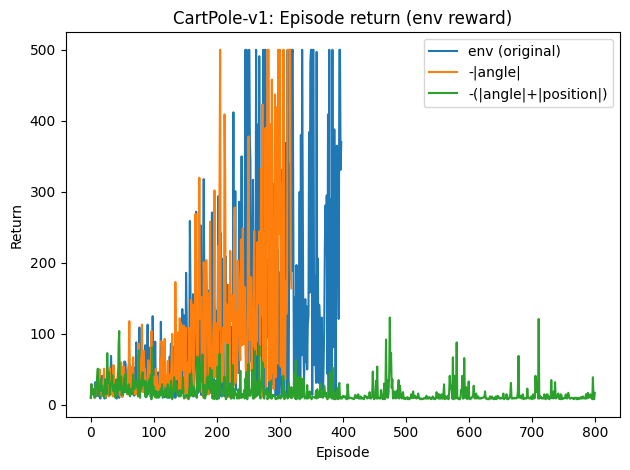

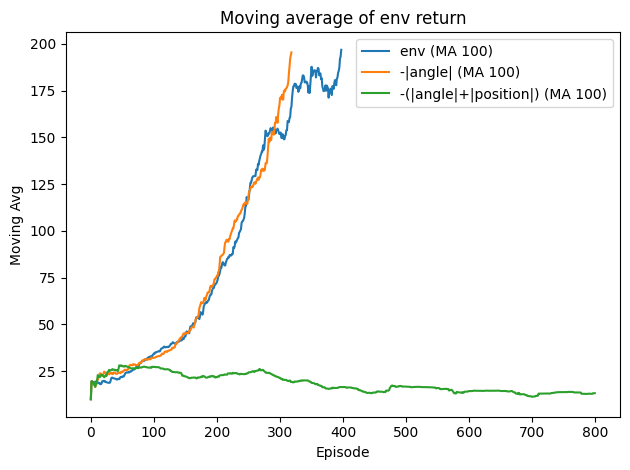


=== Summary ===
         env | solved_ep=398 | lr=0.001 | tgtUpd=100 | batch=64 | epsDecay=0.995
       angle | solved_ep=319 | lr=0.001 | tgtUpd=100 | batch=64 | epsDecay=0.995
   angle_pos | solved_ep=None | lr=0.001 | tgtUpd=100 | batch=64 | epsDecay=0.995

[HPARAM] Running baseline: lr=0.001, tgtUpd=100, batch=64, epsDecay=0.995
[env] ep 001 | return=10.0 | avg100=10.0 | eps=0.995
[env] ep 002 | return=29.0 | avg100=19.5 | eps=0.990
[env] ep 003 | return=20.0 | avg100=19.7 | eps=0.985
[env] ep 004 | return=15.0 | avg100=18.5 | eps=0.980
[env] ep 005 | return=22.0 | avg100=19.2 | eps=0.975
[env] ep 006 | return=15.0 | avg100=18.5 | eps=0.970
[env] ep 007 | return=13.0 | avg100=17.7 | eps=0.966
[env] ep 008 | return=32.0 | avg100=19.5 | eps=0.961
[env] ep 009 | return=12.0 | avg100=18.7 | eps=0.956
[env] ep 010 | return=25.0 | avg100=19.3 | eps=0.951
[env] ep 011 | return=15.0 | avg100=18.9 | eps=0.946
[env] ep 012 | return=14.0 | avg100=18.5 | eps=0.942
[env] ep 013 | return=24.0 |

In [1]:
import math, random, argparse
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

# ----------------------------
# Device & Seeding
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
def set_seed(env, seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    env.reset(seed=seed); env.action_space.seed(seed)

# ----------------------------
#  Baseline Hyperparams
# ----------------------------
ENV_ID = "CartPole-v1"
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
REPLAY_CAPACITY = 10_000
TARGET_UPDATE_STEPS = 100      # every 100 steps
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995              # per-episode multiplier
MAX_EPISODES = 800
SOLVED_THRESHOLD = 195.0
MOVING_WINDOW = 100

# ----------------------------
# Replay Memory
# ----------------------------
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# ----------------------------
# DQN MLP [4,128,128,2]
# ----------------------------
class DQN(nn.Module):
    def __init__(self, n_obs, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(n_obs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# ----------------------------
# Utilities
# ----------------------------
def moving_average(xs, k):
    out = []
    for i in range(len(xs)):
        s = xs[max(0, i-k+1):i+1]
        out.append(sum(s)/len(s))
    return out

def select_action(policy_net, state_t, eps, n_actions):
    if random.random() < eps:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
    with torch.no_grad():
        return policy_net(state_t).argmax(dim=1).view(1, 1)

def optimize_model(policy_net, target_net, optimizer, memory, gamma, batch_size, n_obs):
    if len(memory) < batch_size:
        return 0.0
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor([not d for d in batch.done], device=device, dtype=torch.bool)
    state_batch = torch.stack([torch.tensor(s, dtype=torch.float32, device=device) for s in batch.state])
    action_batch = torch.tensor(batch.action, device=device, dtype=torch.long).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, device=device, dtype=torch.float32)

    if non_final_mask.any():
        non_final_next_states = torch.stack(
            [torch.tensor(s, dtype=torch.float32, device=device) for s, d in zip(batch.next_state, batch.done) if not d]
        )
    else:
        non_final_next_states = torch.empty((0, n_obs), dtype=torch.float32, device=device)

    q_values = policy_net(state_batch).gather(1, action_batch).squeeze(1)
    next_q_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        if non_final_next_states.shape[0] > 0:
            next_q_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected = reward_batch + gamma * next_q_values

    loss = nn.MSELoss()(q_values, expected)
    optimizer.zero_grad(); loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()
    return float(loss.item())

# ----------------------------
# Reward Shaping
# CartPole state = [x, x_dot, theta, theta_dot]
# ----------------------------
def shaped_reward(mode, env_reward, next_state_np):
    if mode == "env":
        return env_reward
    theta = next_state_np[2]
    if mode == "angle":
        return -abs(theta)
    if mode == "angle_pos":
        x = next_state_np[0]
        return -(abs(theta) + abs(x))
    raise ValueError(f"Unknown mode: {mode}")

# ----------------------------
# Training (single run)
# ----------------------------
def train_one(mode="env",
              num_episodes=MAX_EPISODES,
              gamma=GAMMA,
              lr=LR,
              batch_size=BATCH_SIZE,
              replay_capacity=REPLAY_CAPACITY,
              target_update_steps=TARGET_UPDATE_STEPS,
              eps_start=EPS_START,
              eps_end=EPS_END,
              eps_decay=EPS_DECAY,
              seed=SEED):
    env = gym.make(ENV_ID)
    set_seed(env, seed)

    obs, _ = env.reset()
    n_obs = len(obs); n_actions = env.action_space.n

    policy_net = DQN(n_obs, n_actions).to(device)
    target_net = DQN(n_obs, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict()); target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(replay_capacity)

    eps = eps_start
    global_step = 0
    rewards, mov_avg, losses = [], [], []

    for ep in range(1, num_episodes + 1):
        state_np, _ = env.reset()
        state_t = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
        ep_env_return = 0.0

        for t in count():
            action = select_action(policy_net, state_t, eps, n_actions)
            next_state_np, env_reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Use SHAPED reward for learning; env reward for evaluation
            r = shaped_reward(mode, env_reward, next_state_np)
            memory.push(state_np, action.item(), next_state_np, r, done)

            loss_val = optimize_model(policy_net, target_net, optimizer, memory, gamma, batch_size, n_obs)
            if loss_val:
                losses.append(loss_val)

            state_np = next_state_np
            state_t = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
            ep_env_return += env_reward
            global_step += 1

            if global_step % target_update_steps == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        rewards.append(ep_env_return)
        ma = moving_average(rewards, MOVING_WINDOW)[-1]
        mov_avg.append(ma)
        eps = max(eps_end, eps * eps_decay)  # per-episode decay

        print(f"[{mode}] ep {ep:03d} | return={ep_env_return:.1f} | avg{MOVING_WINDOW}={ma:.1f} | eps={eps:.3f}")

        if len(rewards) >= MOVING_WINDOW and ma >= SOLVED_THRESHOLD:
            print(f"[{mode}] solved in {ep} episodes (avg >= {SOLVED_THRESHOLD}).")
            break

    env.close()
    return {
        "mode": mode,
        "config": {
            "gamma": gamma, "lr": lr, "batch_size": batch_size,
            "replay_capacity": replay_capacity, "target_update_steps": target_update_steps,
            "eps_decay": eps_decay, "seed": seed
        },
        "rewards": rewards,
        "moving_avg": mov_avg,
        "losses": losses,
        "solve_episode": next((i+1 for i,v in enumerate(mov_avg) if i+1>=MOVING_WINDOW and v>=SOLVED_THRESHOLD), None)
    }

# ----------------------------
# Plot helpers
# ----------------------------
def plot_three(results_env, results_angle, results_angle_pos):
    plt.figure()
    plt.plot(results_env["rewards"], label="env (original)")
    plt.plot(results_angle["rewards"], label="-|angle|")
    plt.plot(results_angle_pos["rewards"], label="-(|angle|+|position|)")
    plt.title("CartPole-v1: Episode return (env reward)")
    plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(results_env["moving_avg"], label=f"env (MA {MOVING_WINDOW})")
    plt.plot(results_angle["moving_avg"], label=f"-|angle| (MA {MOVING_WINDOW})")
    plt.plot(results_angle_pos["moving_avg"], label=f"-(|angle|+|position|) (MA {MOVING_WINDOW})")
    plt.title("Moving average of env return")
    plt.xlabel("Episode"); plt.ylabel("Moving Avg"); plt.legend(); plt.tight_layout()
    plt.show()

def print_summary(*results):
    print("\n=== Summary ===")
    for r in results:
        cfg = r["config"]
        print(f"{r['mode']:>12} | solved_ep={r['solve_episode']} | "
              f"lr={cfg['lr']} | tgtUpd={cfg['target_update_steps']} | "
              f"batch={cfg['batch_size']} | epsDecay={cfg['eps_decay']}")

# ----------------------------
# Hyperparameter Experiment
# ----------------------------
def run_hparam_sweep():
    configs = [
        {"name":"baseline", "lr":1e-3, "target_update_steps":100, "batch_size":64, "eps_decay":0.995},
        {"name":"faster_target", "lr":1e-3, "target_update_steps":50, "batch_size":64, "eps_decay":0.995},
        {"name":"slower_target", "lr":1e-3, "target_update_steps":200, "batch_size":64, "eps_decay":0.995},
        {"name":"lower_lr", "lr":5e-4, "target_update_steps":100, "batch_size":64, "eps_decay":0.995},
        {"name":"higher_lr", "lr":2e-3, "target_update_steps":100, "batch_size":64, "eps_decay":0.995},
        {"name":"bigger_batch", "lr":1e-3, "target_update_steps":100, "batch_size":128, "eps_decay":0.995},
    ]
    results = []
    for cfg in configs:
        print(f"\n[HPARAM] Running {cfg['name']}: lr={cfg['lr']}, tgtUpd={cfg['target_update_steps']}, "
              f"batch={cfg['batch_size']}, epsDecay={cfg['eps_decay']}")
        r = train_one(
            mode="env",
            lr=cfg["lr"],
            batch_size=cfg["batch_size"],
            target_update_steps=cfg["target_update_steps"],
            eps_decay=cfg["eps_decay"],
        )
        r["mode"] = cfg["name"]
        results.append(r)

    # Print compact table
    print("\n=== Hyperparameter Sweep Results (env reward) ===")
    for r in results:
        cfg = r["config"]
        print(f"{r['mode']:>12} | solved_ep={r['solve_episode']} | "
              f"lr={cfg['lr']:.4g} | tgtUpd={cfg['target_update_steps']:<3d} | "
              f"batch={cfg['batch_size']:<3d} | epsDecay={cfg['eps_decay']}")
    return results

# ----------------------------
# Main: runs baseline+shaping, then hyperparam sweep
# ----------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--episodes", type=int, default=800)
    parser.add_argument("--skip_sweep", action="store_true", help="Skip hyperparameter sweep")
    # Notebook-friendly: ignore unknown flags like "-f <kernel.json>"
    args, _ = parser.parse_known_args()

    # Override global episode cap if provided
    global MAX_EPISODES
    MAX_EPISODES = args.episodes

    # 1) Baseline + two shaped reward runs
    res_env = train_one(mode="env", num_episodes=MAX_EPISODES)
    res_angle = train_one(mode="angle", num_episodes=MAX_EPISODES)
    res_angle_pos = train_one(mode="angle_pos", num_episodes=MAX_EPISODES)

    plot_three(res_env, res_angle, res_angle_pos)
    print_summary(res_env, res_angle, res_angle_pos)

    # 2) Hyperparameter experimentation
    if not args.skip_sweep:
        sweep_results = run_hparam_sweep()
